In [32]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import cv2
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from numpy import genfromtxt

In [33]:
temp = genfromtxt(fname = '/Users/ckruse/Documents/python/OldFaithful/OldFaithful/Old_Faithful_Logger.tsv', delimiter = '	')
time = temp[1:-1,0]
temp = temp[1:-1,1]
np.shape(temp)

(282084,)

In [34]:
#Normalize deltas between -1 and 1

print(np.max(temp))

temp = temp/np.max(temp)*2 - 1
print(np.max(temp))

58.153888888889
1.0


In [35]:
def create_dataset(dataset, labels, look_back):
	dataX, dataY = [], []
	for i in range(0,len(dataset)-look_back-1,1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(labels[i + look_back])
	return np.array(dataX), np.array(dataY)

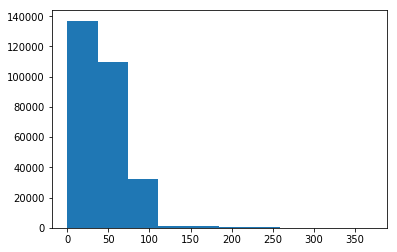

370
1.0


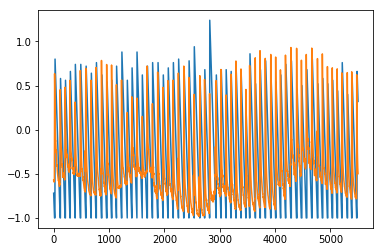

In [61]:
timing = []
i = 0
start = 0
for measurement in range(0, len(temp)):
    
    if temp[measurement] < 0.15:
        timing.append(i)
        i += 1

    else:
        i = 0
        timing.append(i)
        end = measurement
        timing[start:end] = np.max(timing[start:end])-timing[start:end]
        start = measurement


        
plt.hist(timing)
plt.show()
plt.figure(figsize=(6,4))

print(np.max(timing))
timing = np.divide(timing,100)*2 - 1
print(np.max(temp))


plt.plot(timing[0:5500])
plt.plot(temp[0:5500])
plt.show()

(281783, 300)


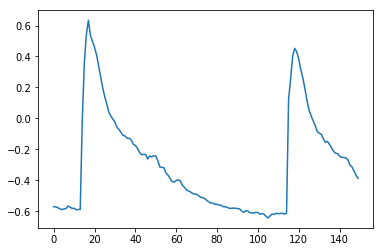

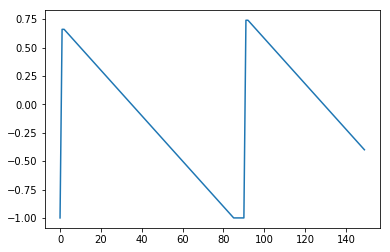

(281783, 300, 1)
(281783,)


In [112]:
X, Y = create_dataset(temp, timing, 300)


print(X.shape)
plt.plot(X[0:150,0])
plt.show()
plt.plot(Y[0:150])
plt.show()
X = X.reshape(X.shape[0], X.shape[1], 1)
Y = Y.reshape(Y.shape[0])

print(X.shape)
print(Y.shape)


In [114]:
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten

model = Sequential()

model.add(Conv1D(filters=8, kernel_size=16, activation='relu', input_shape=(np.shape(X)[1],np.shape(X)[2]), strides=4))
model.add(Conv1D(filters=16, kernel_size=16, activation='relu', strides=4))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['mse'])



Train on 253604 samples, validate on 28179 samples
Epoch 1/15
253604/253604 [==============================] - 8s 30us/step - loss: 0.1227 - mean_squared_error: 0.1227 - val_loss: 0.2957 - val_mean_squared_error: 0.2957
Epoch 2/15
253604/253604 [==============================] - 7s 28us/step - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.2738 - val_mean_squared_error: 0.2738
Epoch 3/15
253604/253604 [==============================] - 7s 30us/step - loss: 0.0879 - mean_squared_error: 0.0879 - val_loss: 0.2773 - val_mean_squared_error: 0.2773
Epoch 4/15
253604/253604 [==============================] - 8s 30us/step - loss: 0.0838 - mean_squared_error: 0.0838 - val_loss: 0.2938 - val_mean_squared_error: 0.2938
Epoch 5/15
253604/253604 [==============================] - 8s 30us/step - loss: 0.0802 - m

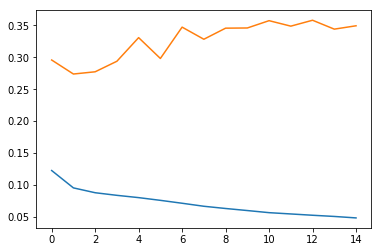

In [115]:
from keras.models import load_model

epochs = 15

#model = load_model('/Users/ckruse/Documents/python/oldFaithfulTemp.h5')
history = model.fit(X,
                    Y,
                    epochs=epochs,
                    verbose=1,
                    batch_size=256,
                    validation_split=0.1,
                    shuffle=True)

model.save('/Users/ckruse/Documents/python/oldFaithfulTemp.h5')
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.show()

#score = model.evaluate(data_stack, label_stack, verbose=1)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])
#model.save('/Users/ckruse/Documents/python/soccer/model.h5')

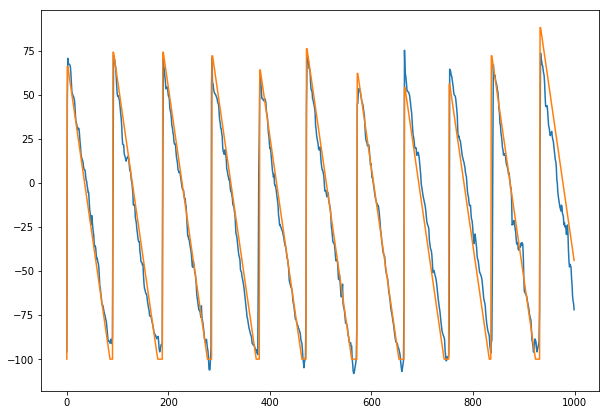

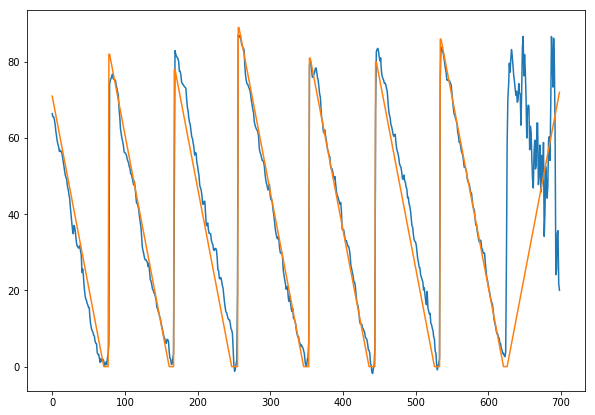

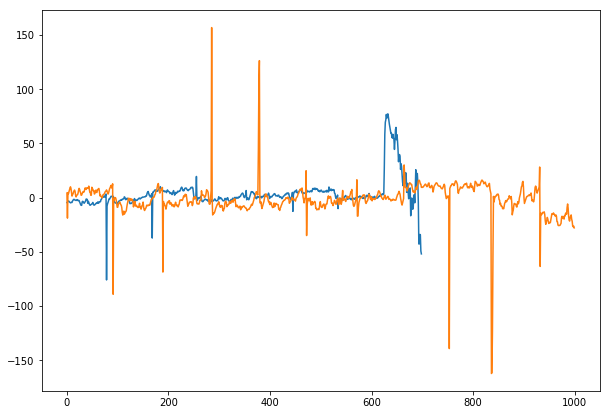

In [116]:
trainPredict = model.predict(X[281084:282084])
trainPredict = ((trainPredict+1)/2)*100
normY = ((Y[281084:282084]+1)/2)*100

plt.figure(figsize=(10,7))
plt.plot(model.predict(X[0:1000])*100)
plt.plot(Y[0:1000]*100)
plt.show()

plt.figure(figsize=(10,7))
plt.plot(trainPredict)
plt.plot(normY)
plt.show()

plt.figure(figsize=(10,7))
plt.plot(np.subtract(trainPredict[:,0],normY))
plt.plot(np.subtract(model.predict(X[0:1000])[:,0]*100,Y[0:1000]*100))
plt.show()


In [17]:
print(trainPredict)
print(Y[0:1])

In [24]:
print(np.shape(X)[1])